# [New MCS features in 2023.09.1](https://greglandrum.github.io/rdkit-blog/posts/2023-10-27-mcswhatsnew.html)

## Custom Python AtomCompare and BondCompare classes

In [2]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

Let’s assume that for some reason we would like to implement a custom MCS criterion that will ignore elements and bond orders/aromaticity in ring systems, while enforcing element and bond order consideration in non-ring portions of the molecules.
This is not something which is readily available among the built-in AtomCompare and BondCompare options; therefore, we will need custom subclasses, respectively derived from AtomCompare and BondCompare classes.

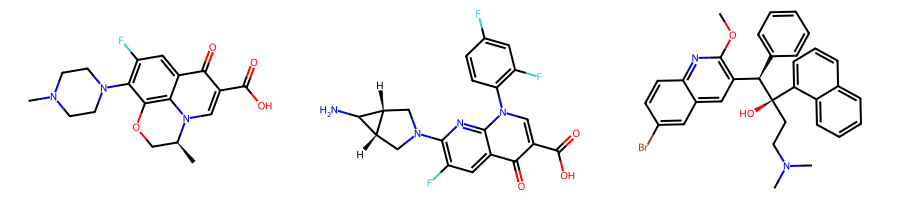

In [4]:
mols = [Chem.MolFromSmiles(smi) for smi in """C[C@H]1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(=O)O
C1[C@@H]2[C@@H](C2N)CN1C3=C(C=C4C(=O)C(=CN(C4=N3)C5=C(C=C(C=C5)F)F)C(=O)O)F
CN(C)CC[C@@](C1=CC=CC2=CC=CC=C21)([C@H](C3=CC=CC=C3)C4=C(N=C5C=CC(=CC5=C4)Br)OC)O
""".split()]
MolsToGridImage(mols, subImgSize=(300, 200))

WIth this rather standard set of parameters, which enforces that ring bonds should only match ring bonds and that rings should be complete, the MCS is 3-methylpyridine:

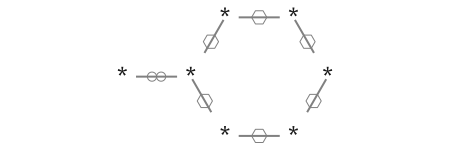

In [12]:
params = rdFMCS.MCSParameters()
params.AtomTyper = rdFMCS.AtomCompare.CompareElements
params.BondTyper = rdFMCS.BondCompare.CompareOrder
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

mcs = rdFMCS.FindMCS(mols, params)
mcs.queryMol

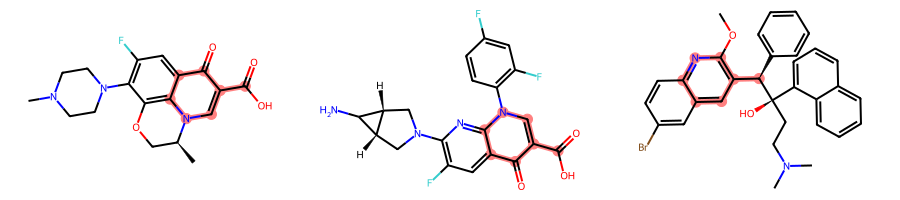

In [11]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

In [14]:
class CompareOrderOutsideRings(rdFMCS.MCSBondCompare):
    def __call__(self, p, mol1, bond1, mol2, bond2):
        b1 = mol1.GetBondWithIdx(bond1)
        b2 = mol2.GetBondWithIdx(bond2)
        if (b1.IsInRing() and b2.IsInRing()) or (b1.GetBondType() == b2.GetBondType()):
            if (p.MatchStereo and not self.CheckBondStereo(p, mol1, bond1, mol2, bond2)):
                return False
            if p.RingMatchesRingOnly:
                return self.CheckBondRingMatch(p, mol1, bond1, mol2, bond2)
            return True
        return False

class CompareElementsOutsideRings(rdFMCS.MCSAtomCompare):
    def __call__(self, p, mol1, atom1, mol2, atom2):
        a1 = mol1.GetAtomWithIdx(atom1)
        a2 = mol2.GetAtomWithIdx(atom2)
        if (a1.GetAtomicNum() != a2.GetAtomicNum()) and not (a1.IsInRing() and a2.IsInRing()):
            return False
        if (p.MatchChiralTag and not self.CheckAtomChirality(p, mol1, atom1, mol2, atom2)):
            return False
        if p.RingMatchesRingOnly:
            return self.CheckAtomRingMatch(p, mol1, atom1, mol2, atom2)
        return True

By using our more lenient atom/bond comparison criterion, while keeping the constraint that ring atoms should only match ring atoms and that rings should be complete, we retrieve a larger MCS:

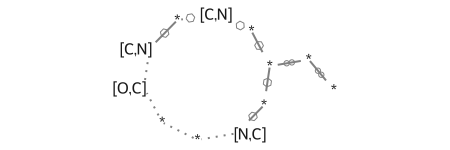

In [16]:
params = rdFMCS.MCSParameters()
params.AtomTyper = CompareElementsOutsideRings()
params.BondTyper = CompareOrderOutsideRings()
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

mcs = rdFMCS.FindMCS(mols, params)
mcs.queryMol

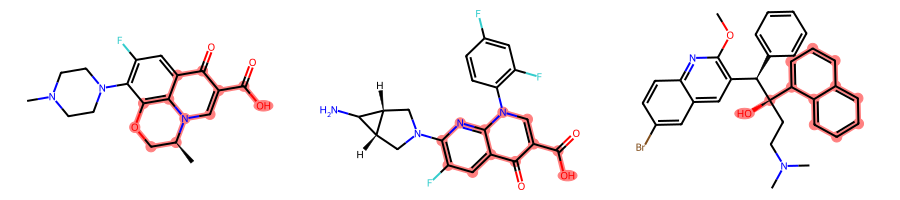

In [17]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

Note that the first molecule can actually match two equivalent ring systems:

In [18]:
[m.GetSubstructMatches(mcs.queryMol) for m in mols]

[((1, 2, 6, 3, 7, 4, 8, 5, 9, 23, 11, 25),
  (5, 4, 6, 14, 7, 13, 8, 12, 9, 23, 11, 25)),
 ((9, 8, 10, 7, 11, 17, 13, 16, 14, 26, 15, 28),),
 ((9, 10, 8, 11, 7, 12, 6, 13, 15, 5, 14, 36),)]

The fact that we instantiate custom compare classes rather than custom compare functions allows to put some non-molecule specific (i.e., static) data that we may need for the comparison in addition to the MCSParameters that get passed to the `__call__` method by the MCS code.
We may access this data stored on the class instance inside the `__call__` method.
For example, let’s assume that we want to enforce that aromatic only matches aromatic based on a user-specified setting.
All we need to do is modify our CompareOrderOutsideRings as follows:

In [19]:
class CompareOrderOutsideRings(rdFMCS.MCSBondCompare):
    def __init__(self, aromatic_match_aromatic=False):
        super().__init__()
        self.aromatic_match_aromatic = aromatic_match_aromatic

    def __call__(self, p, mol1, bond1, mol2, bond2):
        b1 = mol1.GetBondWithIdx(bond1)
        b2 = mol2.GetBondWithIdx(bond2)
        if ((b1.IsInRing() and b2.IsInRing()
            and (not self.aromatic_match_aromatic or not (b1.GetIsAromatic() ^ b2.IsInRing())))
            or b1.GetBondType() == b2.GetBondType()):
            if (p.MatchStereo and not self.CheckBondStereo(p, mol1, bond1, mol2, bond2)):
                return False
            if p.RingMatchesRingOnly:
                return self.CheckBondRingMatch(p, mol1, bond1, mol2, bond2)
            return True
        return False

If we instantiate the CompareOrderOutsideRings class without passing the aromatic_match_aromatic optional parameter, which defaults to False, we will get the same results as before:

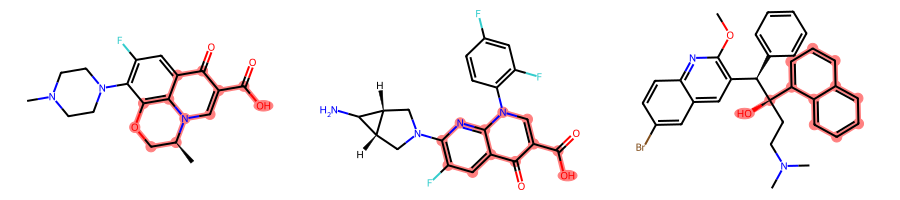

In [22]:
params = rdFMCS.MCSParameters()
params.AtomTyper = CompareElementsOutsideRings()
params.BondTyper = CompareOrderOutsideRings()
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

mcs = rdFMCS.FindMCS(mols, params)

MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

In [23]:
[m.GetSubstructMatches(mcs.queryMol) for m in mols]

[((1, 2, 6, 3, 7, 4, 8, 5, 9, 23, 11, 25),
  (5, 4, 6, 14, 7, 13, 8, 12, 9, 23, 11, 25)),
 ((9, 8, 10, 7, 11, 17, 13, 16, 14, 26, 15, 28),),
 ((9, 10, 8, 11, 7, 12, 6, 13, 15, 5, 14, 36),)]

However, if we instantiate the CompareOrderOutsideRings class setting the aromatic_match_aromatic optional parameter to True, the first molecule will match only on the quinoline ring system:

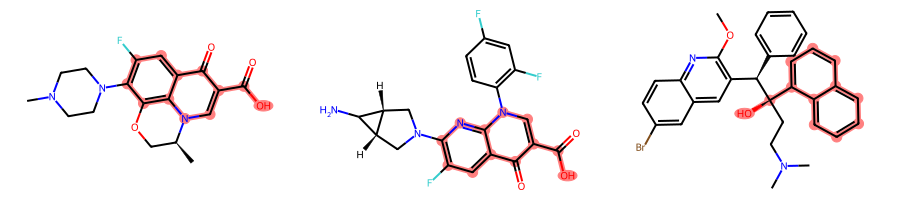

In [24]:
params = rdFMCS.MCSParameters()
params.AtomTyper = CompareElementsOutsideRings()
params.BondTyper = CompareOrderOutsideRings(True)
params.BondCompareParameters.RingMatchesRingOnly = True
params.BondCompareParameters.CompleteRingsOnly = True

mcs = rdFMCS.FindMCS(mols, params)

MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

In [25]:
[m.GetSubstructMatches(mcs.queryMol) for m in mols]

[((4, 5, 14, 6, 13, 7, 12, 8, 11, 9, 23, 25),),
 ((8, 9, 7, 10, 17, 11, 16, 13, 15, 14, 26, 28),),
 ((10, 9, 11, 8, 12, 7, 13, 6, 14, 15, 5, 36),)]

## Retrieve all degenerate MCSs

It may happen that there are multiple degenerate MCSs (i.e., with the same size) across a set of molecules.
Before my PR, the MCS algorithm implemented in RDKit would return only one of them, but which one would be rather unpredictable, as it depends on atom ordering in the molecules.
This topic was raised during an RDKit UGM 2-3 years ago, but I did not realize its importance until one of my colleagues was bitten by the degenerate MCS issue.
Now there is an optional StoreAll parameter, which defaults to False, which if set to True will trigger the storage of all degenerate MCSs in an array.
See below for an example.

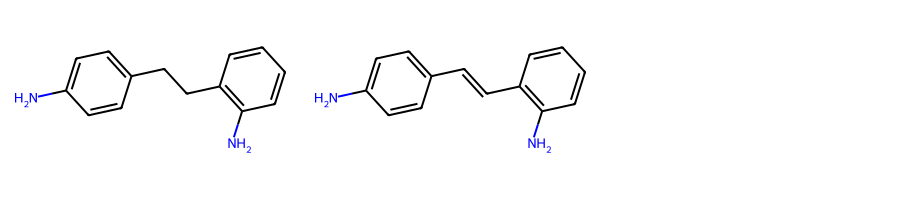

In [26]:
mols = [Chem.MolFromSmiles(smi) for smi in [
    "Nc1ccc(cc1)C-Cc1c(N)cccc1",
    "Nc1ccc(cc1)C=Cc1c(N)cccc1"]
]
MolsToGridImage(mols, subImgSize=(300, 200))

You can see at a glance that two degenerate MCSs can be found between the above molecules, i.e., o-methylaniline and p-methylaniline.
However, by default rdFMCS will only find one, in this case the para isomer:

In [28]:
mcs = rdFMCS.FindMCS(mols)
mcs.numAtoms, mcs.numBonds

(8, 8)

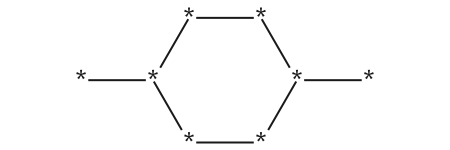

In [29]:
mcs.queryMol

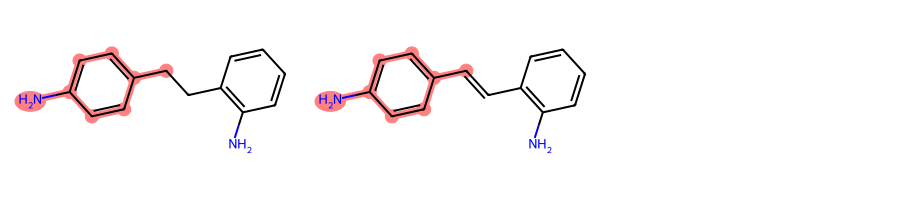

In [30]:
MolsToGridImage(mols, subImgSize=(300, 200), highlightAtomLists=[m.GetSubstructMatch(mcs.queryMol) for m in mols])

In [31]:
params = rdFMCS.MCSParameters()
params.StoreAll = True

mcs = rdFMCS.FindMCS(mols, params)

The number of atoms and bonds that constitute the MCS, as expected, are the same as before, since the MCSs are degenerate:

In [32]:
mcs.numAtoms, mcs.numBonds

(8, 8)

However, this time mcs.queryMol and mcs.smartsString are None and '', respectively.
This is by design, as with StoreAll we need to be able to potentially access multiple MCSs, rather than only one as is the case for the MCSResult.queryMol and MCSResult.smartsString properties.
The property that allows to browse all degenerate MCSs is MCSResult.degenerateSmartsQueryMolDict, which is a dict:

In [33]:
mcs.queryMol

In [34]:
mcs.smartsString

''

In [35]:
mcs.degenerateSmartsQueryMolDict

{'[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#7]': <rdkit.Chem.rdchem.Mol at 0x1f51c88dbd0>,
 '[#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]': <rdkit.Chem.rdchem.Mol at 0x1f51c88dcb0>}

Below I show all degenerate MCSs found, labelled with their respective SMARTS pattern:

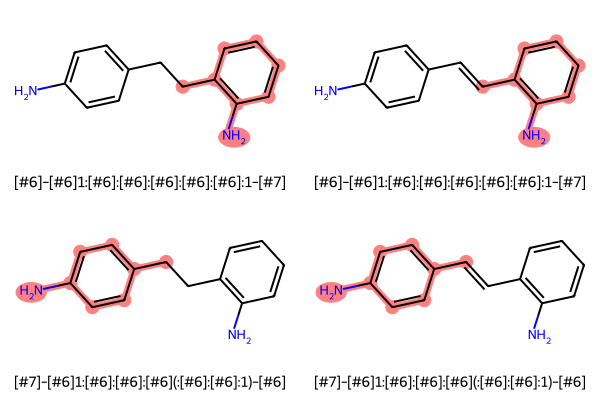

In [36]:
mols_highlights_smarts_list = [[mols, [m.GetSubstructMatch(query) for m in mols], [smarts for _ in mols]] for smarts, query in mcs.degenerateSmartsQueryMolDict.items()]
mols_to_display, highlight_atom_lists, legends = [sum(item, []) for item in map(list, list(zip(*mols_highlights_smarts_list)))]
MolsToGridImage(mols_to_display, molsPerRow=2, subImgSize=(300, 200), highlightAtomLists=highlight_atom_lists, legends=legends)

## there is more but i think i won't need it